In [1]:
import pandas as pd
from src.train import train_loop, test_loop
from src.model import CNNLSTMModel
from src.dataset import InverterTimeSeriesDataset
from src.preprocess import *
from src.visualize import *
import torch


## Hyper-Parameter

In [24]:
performe_visualization = True

In [ ]:
# some important parameters
pre_day = 7
window_size = 12*24 # 5 minutes * 12 * 24 * 3 = 3 day
stride = 12 # 1 hour stride

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED"                     # DC voltage
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')] # anomalies in the data
]

## Data Preprocessing
### Load Data

In [3]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [ ]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization/raw_data/')

### Data Cleaning

In [5]:
print("inverter_data shape:", inverter_data.shape)
excluded_data = exclude_periods_from_data(inverter_data, exclude_periods)
print("Excluded data shape:", excluded_data.shape)

inverter_data shape: (6126272, 59)
Excluded data shape: (5172608, 59)


In [ ]:
selected_data = excluded_data[['event_local_time', 'device_name'] + feature_cols]
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(selected_data, failure_sessions, feature_cols, 'visualization/filtered_data/')

### Data Labeling

In [8]:
labeled_df = prepare_dataset(selected_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 86268
Total rows: 5026798


### Missing Value Mask

In [9]:
def generate_missing_value_mask(df: pd.DataFrame, features_cols: list[str]) -> pd.DataFrame:
    # Step 1: 缺失 mask
    for col in features_cols:
        df[f"{col}_missing"] = df[col].isna().astype(int)
        
generate_missing_value_mask(labeled_df, feature_cols)

### Missing Value Imputation

In [10]:
from typing import List

def missing_value_imputation(
    df: pd.DataFrame,
    feature_cols: List[str],
    time_col: str = "event_local_time",
    device_col: str = "device_name",
    short_gap_limit: int = 6,   # 5 分鐘資料 -> 6 筆 ≈ 30 分鐘內用插值
    long_fill_value: float = 0.0,
    add_missing_mask: bool = True,
) -> pd.DataFrame:
    """
    針對多裝置時間序列做缺失補值：
      1) 先產生 per-step 缺失 mask（可選）
      2) 每個裝置內，以時間排序後對 feature 做「時間型插值」(limit=short_gap_limit)
      3) 尚未補到的長缺失以指定值（預設 0）補齊

    參數：
      - df: 原始 DataFrame，需包含 time_col 與 device_col
      - feature_cols: 要補值的數值欄位
      - time_col: 時間欄位名稱（需可轉為 datetime）
      - device_col: 裝置欄位名稱
      - short_gap_limit: 連續缺失筆數在此上限以內使用插值
      - long_fill_value: 插值後仍為 NaN 的長缺失以此值補
      - add_missing_mask: 是否為每個 feature 產生 *_missing 的 0/1 mask 欄位

    回傳：
      - 完成補值與（可選）新增 mask 的 DataFrame
    """
    imputed_df = df.copy()

    # 確保時間欄為 datetime
    imputed_df[time_col] = pd.to_datetime(imputed_df[time_col], errors="coerce")

    # 需要的欄位存在性檢查
    missing_cols = [c for c in [time_col, device_col] + feature_cols if c not in imputed_df.columns]
    if missing_cols:
        raise KeyError(f"Columns not found in df: {missing_cols}")

    for device, device_data in imputed_df.groupby(device_col, sort=False):
        # 複製避免 SettingWithCopy
        block = device_data.loc[:, [time_col, device_col] + feature_cols].copy()
        # 記住原始索引以便放回
        block["_orig_idx"] = block.index

        # 產生 per-step 缺失 mask（基於原始缺失）
        if add_missing_mask:
            for col in feature_cols:
                imputed_df.loc[block["_orig_idx"], f"{col}_missing"] = block[col].isna().astype(int)

        # 依時間排序並以時間為索引做 time-based interpolate
        block = block.sort_values(time_col)
        block = block.set_index(time_col)

        # 僅對目標特徵做處理
        # 短缺失：時間插值（雙向皆可，避免前段或尾段全 NaN 無法補）
        block[feature_cols] = block[feature_cols].interpolate(
            method="time", limit=short_gap_limit
        ).interpolate(method="time", limit_direction="both")

        # 長缺失：仍為 NaN 的以指定值補齊
        block[feature_cols] = block[feature_cols].fillna(long_fill_value)

        # 還原索引與順序
        block = block.reset_index()
        block = block.set_index("_orig_idx").sort_index()

        # 寫回 imputed_df（僅覆蓋目標特徵欄）
        imputed_df.loc[block.index, feature_cols] = block[feature_cols].values

    return imputed_df


In [11]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=6, long_fill_value=0.0, add_missing_mask=True)

### Split Dataset

In [12]:
train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
val_df, test_df = train_test_split_on_time(test_df, 0.3)

Train set size: 3518759 Train set time range: 2021-12-24 00:00:00 to 2024-08-16 09:30:00
Test set size: 1508039 Test set time range: 2024-08-16 09:30:00 to 2025-07-23 23:35:00
Train set size: 1055628 Train set time range: 2024-08-16 09:30:00 to 2025-04-03 12:30:00
Test set size: 452411 Test set time range: 2025-04-03 12:30:00 to 2025-07-23 23:35:00


### Standardization

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

In [14]:
feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

In [15]:
#visualize_hourly_mean_values(train_df, failure_sessions, feature_cols, 'visualization/train_data/')

In [16]:
visualize_hourly_mean_values(val_df, failure_sessions, feature_cols+['label'], 'visualization/validation_data/')

Visualization saved for device: INV 62 at visualization/validation_data//INV 62.html
Visualization saved for device: INV 60 at visualization/validation_data//INV 60.html
Visualization saved for device: INV 53 at visualization/validation_data//INV 53.html
Visualization saved for device: INV 58 at visualization/validation_data//INV 58.html
Visualization saved for device: INV 56 at visualization/validation_data//INV 56.html
Visualization saved for device: INV 61 at visualization/validation_data//INV 61.html
Visualization saved for device: INV 52 at visualization/validation_data//INV 52.html
Visualization saved for device: INV 64 at visualization/validation_data//INV 64.html
Visualization saved for device: INV 57 at visualization/validation_data//INV 57.html
Visualization saved for device: INV 59 at visualization/validation_data//INV 59.html
Visualization saved for device: INV 51 at visualization/validation_data//INV 51.html
Visualization saved for device: INV 63 at visualization/validatio

### Create Dataset/Data Loader

In [17]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset(train_df, feature_cols, under_sample=True, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset(val_df,   feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset(test_df,  feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 36.89it/s]


In [18]:
train_ds.X.shape

torch.Size([9578, 288, 8])

In [19]:
pd.value_counts(val_ds.y.numpy()).sort_index()

0.0    86679
1.0      491
dtype: int64

In [20]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    4789
 1.0    4789
 dtype: int64,
 0.0    86679
 1.0      491
 dtype: int64,
 0.0    35271
 1.0     1776
 dtype: int64)

In [21]:
batch_size = 2**8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [22]:
model = CNNLSTMModel(num_features=len(feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [ ]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=10, 
    num_epochs=30, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=5
)

### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(model, data_loader):
    trues, predictions, outputs = test_loop(model, data_loader, device='cuda', criterion=criterion)
    print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
    print(confusion_matrix(trues, predictions ))
    roc_auc = roc_auc_score(trues, outputs)
    print(f"ROC AUC: {roc_auc:.4f}")
    curve = roc_curve(trues, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(curve[0], curve[1], label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [ ]:
model = CNNLSTMModel(num_features=len(feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
model.load_state_dict(torch.load(r'model\0811_1634\epoch_29.pth', weights_only=True))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



<All keys matched successfully>

Performance on Training Set:
🔍 Test Loss: 0.2155 | Accuracy: 61.41%
              precision    recall  f1-score   support

      Normal       0.60      0.69      0.64      4789
     Failure       0.63      0.54      0.58      4789

    accuracy                           0.61      9578
   macro avg       0.62      0.61      0.61      9578
weighted avg       0.62      0.61      0.61      9578

[[3310 1479]
 [2217 2572]]
ROC AUC: 0.6873


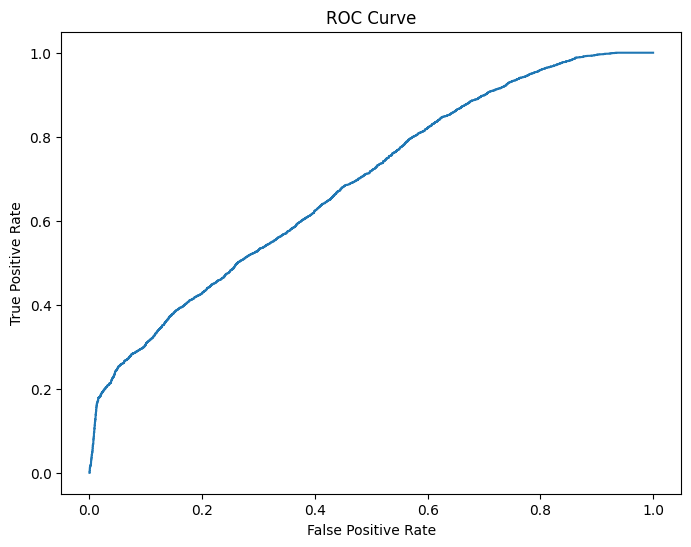

In [ ]:
print("Performance on Training Set:")
evaluate_model(model, train_loader)

Performance on Validation Set:
🔍 Test Loss: 0.1548 | Accuracy: 82.50%
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.90     86679
     Failure       0.01      0.27      0.02       491

    accuracy                           0.82     87170
   macro avg       0.50      0.55      0.46     87170
weighted avg       0.99      0.82      0.90     87170

[[71782 14897]
 [  360   131]]
ROC AUC: 0.6827


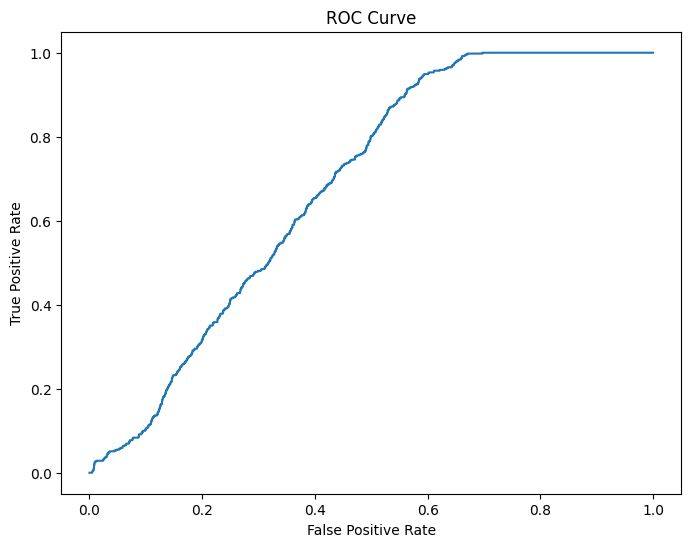

In [ ]:
print("Performance on Validation Set:")
evaluate_model(model, val_loader)

Performance on Test Set:
🔍 Test Loss: 0.1595 | Accuracy: 85.55%
              precision    recall  f1-score   support

      Normal       0.95      0.89      0.92     35271
     Failure       0.06      0.14      0.09      1776

    accuracy                           0.86     37047
   macro avg       0.51      0.52      0.50     37047
weighted avg       0.91      0.86      0.88     37047

[[31438  3833]
 [ 1519   257]]
ROC AUC: 0.5176


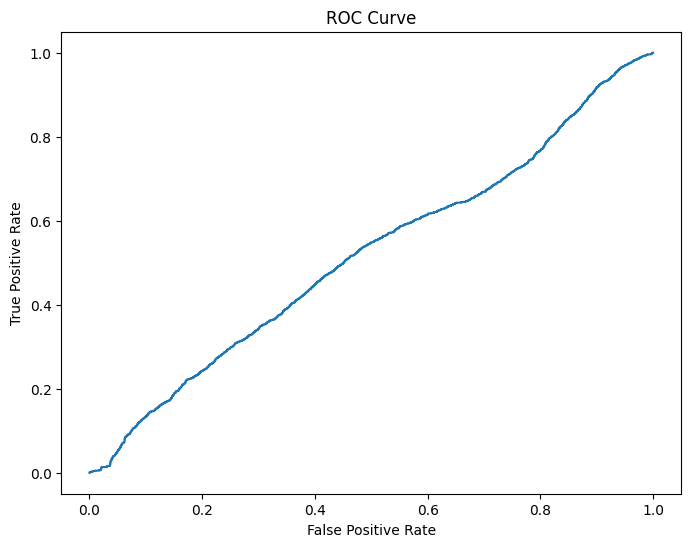

In [ ]:
print("Performance on Test Set:")
evaluate_model(model, test_loader)